In [74]:
# notebook created using the following module versions:
# python 3.6.10
# astropy 4.0.1.post1
# matplotlib 3.1.3
# numpy 1.18.1

from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.time import Time
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

# paths to the CV3 and OTIS dark files
CV3_DIR = '/ifs/jwst/wit/nircam/isim_cv3_files_for_calibrations/darks/'
OTIS_DIR = '/ifs/jwst/wit/witserv/data7/nrc/otis_long_darks/'

# nircam amp boundaries
AMP_BOUNDARIES = {'1': [(0, 512), (0, 2048)],
                  '2': [(512, 1024), (0, 2048)],
                  '3': [(1024, 1536), (0, 2048)],
                  '4': [(1536, 2048), (0, 2048)]}

# Dark Current Levels Over Time

/ifs/jwst/wit/nircam/isim_cv3_files_for_calibrations/darks/A1/NRCNRCA1-DARK-60011933591_1_481_SE_2016-01-01T20h04m44_level1b_Sept2018_uncal.fits
/ifs/jwst/wit/nircam/isim_cv3_files_for_calibrations/darks/A1/NRCNRCA1-DARK-60012216201_1_481_SE_2016-01-02T02h34m28_level1b_Sept2018_uncal.fits
/ifs/jwst/wit/nircam/isim_cv3_files_for_calibrations/darks/A1/NRCNRCA1-DARK-60020354361_1_481_SE_2016-01-02T07h09m09_level1b_Sept2018_uncal.fits


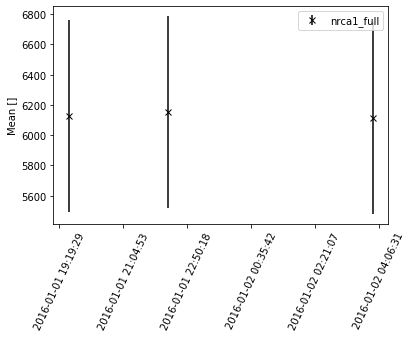

In [128]:
# Plot the dark current/noise levels over time

########################################## USER INPUTS ##########################################

# the dark files of interest - darks located in different paths can be appended with '+'
files = sorted(glob.glob(os.path.join(CV3_DIR, 'A1/*Sept2018_uncal.fits')) + 
               [])

# the types of darks (detector/subarray) to include, and their color/label on the plot
dark_table = Table({'detector': ['NRCA1', 'NRCA1'],
                    'subarray': ['FULL', 'SUBGRISM256'],
                    'color': ['black', 'red'],
                    'label': ['nrca1_full', 'nrca1_subgrism256']})

# the int/group (0 is first) to measure the dark current in
integration = 0
group = 0

# same as above, but ground test data only has 1 int and a different number of groups,
# so you may want different values
ground_integration = 0
ground_group = 0

# the amp to measure the dark current in: either '1', '2', '3', '4', or 'all'
amp = '1'

# the columns to measure the dark current in: either 'odd', 'even', or 'all'
columns = 'even'

# how the x axis is scaled: either 'time' to plot by expstart, or 'sequence' to plot by the 
# (equally-spaced) dark image number in the time-ordered sequence. The latter may be useful 
# when the time between the dark populations (e.g. CV3 and commissioning) is long, to avoid 
# all of the data points within these two populations from overlapping on the plot.
x_scale = 'time'

# save the figure?
save_fig = False
save_fig_name = 'A1_dark_analysis.png'

#################################################################################################


# Put darks in time order
times = ['{}T{}'.format(fits.getheader(f, 0)['DATE-OBS'], fits.getheader(f, 0)['TIME-OBS']) for f in files]
times = Time(times, format='isot').mjd
order = np.argsort(times)
files = np.array(files)[order]

# Plot the average signal/error for each dark file
for i,f in enumerate(files[0:3]):
    print(f)
    h = fits.open(f)
    header = h[0].header
    data = h['SCI'].data
    try:
        bunit = h['SCI'].header['BUNIT']
    except KeyError:
        bunit = ''
    h.close()
    
    # Get info about this dark file
    n_dim = len(data.shape)
    if n_dim==4:
        nints, ngroups, ny, nx = data.shape
        file_type = 'uncal'
    elif n_dim==3:
        nints, ny, nx = data.shape
        file_type = 'rateints'
    else:
        ny, nx = data.shape
        file_type = 'rate'
    detector, subarray = header['DETECTOR'], header['SUBARRAY']
    entry = dark_table[(dark_table['detector']==detector) & (dark_table['subarray']==subarray)]
    if len(entry)==0:
        continue
    color = entry['color'][0]
    label = entry['label'][0]
    
    # Get the relevant slice of data
    if (CV3_DIR in f) | (OTIS_DIR in f):
        fmt = 'x'
        if file_type == 'uncal':
            data = data[ground_integration, ground_group]
        elif file_type == 'rateints':
            data = data[ground_integration]
    else:
        fmt = 'o'
        if file_type == 'uncal':
            data = data[integration, group]
        elif file_type == 'rateints':
            data = data[integration]
    if (subarray == 'FULL') & (amp != 'all'):  # subarrays all readout through single amp
        xstart, xend = AMP_BOUNDARIES[amp][0]
        ystart, yend = AMP_BOUNDARIES[amp][1]
        data = data[ystart:yend, xstart:xend]
    if columns == 'odd':
        data = data[:, ::2]
    if columns == 'even':
        data = data[:, 1::2]
        
    # Get the mean/stddev values
    clipped = sigma_clip(data, sigma=3, maxiters=5)
    mean, stddev = np.nanmean(clipped), np.nanstd(clipped)
    
    # Get the x axis (e.g. time) value
    if x_scale == 'time':
        dt = '{}T{}'.format(header['DATE-OBS'], header['TIME-OBS'])
        dt_decimal = Time(dt, format='isot').decimalyear
        time = dt_decimal
    elif x_scale == 'sequence':
        time = i
    else:
        print('Warning: {} is not a valid value for x_scale, using sequence...'.format(x_scale))
        time = i
        
    # Plot the data
    plt.errorbar(time, mean, yerr=stddev, ecolor=color, linestyle='None', fmt=fmt, color=color, label=label)

# Format/save plot
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # removes duplicate legend labels
plt.legend(by_label.values(), by_label.keys())
plt.ylabel('Mean []'.format(bunit))
if x_scale == 'time':
    time_ticks = Time(ax.get_xticks(), format='decimalyear')
    time_ticks = [t.split('.')[0] for t in time_ticks.iso]  # remove fractional seconds from label
    ax.set_xticklabels(time_ticks, rotation=65)
else:
    plt.xlabel('Dark Number')
if save_fig:
    plt.savefig(save_fig_name, dpi=200, bbox_inches='tight')
